# **Object Tracking and Annotation System**

## Overview
This project provides a complete pipeline for **object detection, annotation, tracking, and visualization** using a combination of **manual annotations, YOLO-based detection, and KCF tracking**. The system allows users to manually annotate objects in video frames, track them using the **Kernelized Correlation Filters (KCF) tracker**, and compare results between manual annotations and tracking-based detections.

## Features
- **Frame Extraction**: Extracts frames from a video at a specified FPS.
- **Manual Annotation Tool**: Allows users to manually draw bounding boxes on objects in each frame.
- **KCF Object Tracking**: Uses the KCF tracker to track objects across frames.
- **YOLO-Based Object Detection**: Detects objects when tracking fails and reinitializes tracking.
- **Annotation Comparison**: Compares manually labeled bounding boxes with KCF tracking results.
- **Visualization & Output**:
  - Saves tracking results as **annotated images** and **videos**.
  - Outputs **CSV annotation files** for further analysis.

## Workflow
1. **Frame Extraction**  
   - Extracts frames from a video and saves them as images.
   
2. **Manual Annotation**  
   - Loads frames and allows users to draw bounding boxes.
   - Saves annotations to a ΤΧΤ file.

3. **Object Tracking (KCF + YOLO Fallback)**  
   - Uses **manual annotations** to initialize tracking on the first frame.
   - Tracks objects across frames using **KCF**.
   - If tracking fails, **YOLO detects objects** and reinitializes tracking.
   - Saves tracking results as a **video with bounding boxes**.

4. **Annotation Comparison**  
   - Loads manual and KCF annotations.
   - Displays bounding boxes for comparison (green = manual, red = KCF).
   - Allows frame-by-frame inspection.

## Dependencies
- `Python 3.x`
- `OpenCV (cv2)`
- `pandas`
- `numpy`
- `glob`
- `re`
- `ultralytics` (for YOLO model)


### Import statements

In [5]:
import cv2
import os
import re
from ultralytics import YOLO
import contextlib
import numpy as np
import urllib.request
import pandas as pd
import glob
import matplotlib.pyplot as plt


HOME = os.getcwd()
print("HOME:",HOME)

MODEL_PATH_AUGMENTED = "/Users/Mac_1/Documents/Development/1.Projects/CV/CV-Final/models/yolov8s-bs-augmented/train/weights/best.pt"


# Define video path
tracking_path = f"{HOME}/video_tracking"
video_path = "/Users/Mac_1/Documents/Development/1.Projects/CV/CV-Final/datasets/Raw-Video/banana-slug-cropped.mp4"  # Replace with your video file
output_video = f"{HOME}/video_tracking/banana_slug_track.mp4"
save_frames = True  # Set to False to disable frame saving
annotation_file = f"{HOME}/video_tracking/annotations.txt"
output_dir = f"{HOME}/video_tracking/annotation_frames"
# frames_dir = f"{HOME}/video_tracking/frames"

fps = 10  # Change to 3 for 3Hz

print("Video Path:",video_path)
print("Output Video:",output_video)

HOME: /Users/Mac_1/Documents/Development/1.Projects/CV/CV-Final
Video Path: /Users/Mac_1/Documents/Development/1.Projects/CV/CV-Final/datasets/Raw-Video/banana-slug-cropped.mp4
Output Video: /Users/Mac_1/Documents/Development/1.Projects/CV/CV-Final/video_tracking/banana_slug_track.mp4


# Video Frame Extraction Script

## Overview
This script extracts frames from a video at a specified frames-per-second (FPS) rate for a given duration and saves them as images.

## Features
- Extracts frames from a video for a specified duration.
- Captures frames at a defined FPS rate.
- Saves extracted frames as `.jpg` images in the specified output directory.
- Ensures the output directory exists before saving frames.

## Parameters
- `duration`: The total duration (in seconds) for which frames are extracted.
- `fps`: The number of frames per second to extract.
- `frame_interval`: The interval between frames to be saved, calculated as `30 / fps`.
- `video_path`: The path to the input video file.
- `output_dir`: The directory where extracted frames will be saved.

## How It Works
1. Opens the input video and retrieves its total frame count and FPS.
2. Iterates through the video frames while ensuring the specified duration is not exceeded.
3. Saves every `Nth` frame (based on `frame_interval`) as a `.jpg` file.
4. Stops extraction when the required number of frames is reached.

## Dependencies
- `cv2` (OpenCV)
- `os`

## Example Usage
```python
video_path = "path/to/video.mp4"
output_dir = "output_frames"
fps = 5  # Extract 5 frames per second


In [2]:
# Parameters
duration = 30  # 30 seconds
frame_interval = int(30 / fps)  # Capture every Nth frame

# Ensure output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Open video
cap = cv2.VideoCapture(video_path)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
video_fps = int(cap.get(cv2.CAP_PROP_FPS))

print(f"Video FPS: {video_fps}, Extracting at {fps} FPS for {duration} sec")

frame_count = 0
saved_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret or saved_count >= fps * duration:
        break

    # Save only every Nth frame
    if frame_count % frame_interval == 0:
        frame_path = os.path.join(output_dir, f"frame_{saved_count + 1}.jpg")
        cv2.imwrite(frame_path, frame)
        print(f"Saved {frame_path}")
        saved_count += 1

    frame_count += 1

cap.release()
print("Frame extraction complete.")


Video FPS: 29, Extracting at 10 FPS for 30 sec
Saved /Users/Mac_1/Documents/Development/1.Projects/CV/CV-Final/video_tracking/annotation_frames/frame_1.jpg
Saved /Users/Mac_1/Documents/Development/1.Projects/CV/CV-Final/video_tracking/annotation_frames/frame_2.jpg
Saved /Users/Mac_1/Documents/Development/1.Projects/CV/CV-Final/video_tracking/annotation_frames/frame_3.jpg
Saved /Users/Mac_1/Documents/Development/1.Projects/CV/CV-Final/video_tracking/annotation_frames/frame_4.jpg
Saved /Users/Mac_1/Documents/Development/1.Projects/CV/CV-Final/video_tracking/annotation_frames/frame_5.jpg
Saved /Users/Mac_1/Documents/Development/1.Projects/CV/CV-Final/video_tracking/annotation_frames/frame_6.jpg
Saved /Users/Mac_1/Documents/Development/1.Projects/CV/CV-Final/video_tracking/annotation_frames/frame_7.jpg
Saved /Users/Mac_1/Documents/Development/1.Projects/CV/CV-Final/video_tracking/annotation_frames/frame_8.jpg
Saved /Users/Mac_1/Documents/Development/1.Projects/CV/CV-Final/video_tracking/an

# Image Annotation Tool

## Overview
This script provides an interactive annotation tool for labeling bounding boxes on extracted video frames. Users can draw, navigate, and save annotations for each frame.

## Features
- Loads images from a specified directory and sorts them naturally.
- Allows drawing and removing bounding boxes using the mouse.
- Supports navigation between frames (`n` for next, `b` for previous).
- Saves annotations in a `.txt` file with bounding box coordinates.

## Parameters
- `image_dir`: The directory containing extracted frames.
- `annotation_file`: The file where annotations are stored.
- `current_image_idx`: Tracks the currently displayed image.
- `current_box`: Stores the bounding box coordinates for the active frame.
- `drawing`: Flag indicating whether a bounding box is being drawn.

## Mouse Controls
- **Left-click (`LBUTTONDOWN`)**: Start drawing a bounding box.
- **Drag (`MOUSEMOVE`)**: Update the rectangle while holding the left mouse button.
- **Left-click release (`LBUTTONUP`)**: Finish drawing the bounding box.
- **Right-click (`RBUTTONDOWN`)**: Remove the current bounding box.

## Keyboard Controls
- **`s`**: Save annotations to file and continue.

## How It Works
1. Loads existing annotations if available.
2. Displays an image and allows drawing a bounding box.
3. Uses keyboard shortcuts to navigate and save annotations.
4. Writes annotations to a TXT file in the format:


In [ ]:
def natural_sort_key(filename):
    """Extract numbers from filenames to ensure correct numerical sorting."""
    return [int(text) if text.isdigit() else text for text in re.split(r'(\d+)', filename)]

# Paths
image_dir = output_dir
images = sorted(os.listdir(image_dir), key=natural_sort_key)  # Natural sorting
annotations = {}

# Load existing annotations if available
if os.path.exists(annotation_file):
    with open(annotation_file, "r") as f:
        for line in f:
            parts = line.strip().split(",")
            frame_name = parts[0]
            boxes = [tuple(map(int, parts[i:i+4])) for i in range(1, len(parts), 4)]
            annotations[frame_name] = boxes

# Global variables
current_image_idx = 0
current_box = None  # Store only one box per frame
drawing = False
start_x, start_y = -1, -1

# Mouse callback function
def draw_bbox(event, x, y, flags, param):
    global start_x, start_y, drawing, current_box

    if event == cv2.EVENT_LBUTTONDOWN:  # Start drawing
        start_x, start_y = x, y
        drawing = True

    elif event == cv2.EVENT_MOUSEMOVE and drawing:  # Update drawing
        frame = cv2.imread(os.path.join(image_dir, images[current_image_idx]))
        if current_box:
            cv2.rectangle(frame, (current_box[0], current_box[1]), (current_box[2], current_box[3]), (0, 255, 0), 2)
        cv2.rectangle(frame, (start_x, start_y), (x, y), (0, 0, 255), 2)
        cv2.imshow("Annotate", frame)

    elif event == cv2.EVENT_LBUTTONUP:  # Finish drawing
        current_box = (start_x, start_y, x, y)
        drawing = False

    elif event == cv2.EVENT_RBUTTONDOWN:  # Remove box
        current_box = None  # Clear selection

# Annotation loop
while current_image_idx < len(images):
    frame_path = os.path.join(image_dir, images[current_image_idx])
    img = cv2.imread(frame_path)

    if images[current_image_idx] in annotations:
        current_box = annotations[images[current_image_idx]][0]  # Load previous box if available

    # Draw existing box before showing the image
    if current_box:
        cv2.rectangle(img, (current_box[0], current_box[1]), (current_box[2], current_box[3]), (0, 255, 0), 2)

    cv2.imshow("Annotate", img)
    cv2.setMouseCallback("Annotate", draw_bbox)

    while True:
        key = cv2.waitKey(0) & 0xFF

        if key == ord('n'):  # Next frame
            if current_box:
                annotations[images[current_image_idx]] = [current_box]
            current_box = None  # Reset selection
            drawing = False  # Reset drawing state
            current_image_idx = min(current_image_idx + 1, len(images) - 1)  # Ensure within bounds
            break

        elif key == ord('b') and current_image_idx > 0:  # Previous frame
            current_image_idx -= 1
            current_box = annotations.get(images[current_image_idx], [None])[0]  # Load previous annotation
            break

        elif key == ord('s'):  # Save and move to next frame
            if current_box:
                annotations[images[current_image_idx]] = [current_box]
            with open(annotation_file, "w") as f:
                for frame_name, bbox_list in annotations.items():
                    bbox_str = ",".join([f"{x1},{y1},{x2},{y2}" for (x1, y1, x2, y2) in bbox_list])
                    f.write(f"{frame_name},{bbox_str}\n")
            print(f"Saved annotations for {images[current_image_idx]}")

            if current_image_idx < len(images) - 1:
                current_image_idx += 1
                current_box = None  # Reset for new frame
                break
            else:
                print("Annotation complete.")
                break
                # exit()


cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)# Final cleanup
print("All frames annotated and saved. Exiting.")
exit()



2025-03-14 13:44:31.688 python[17603:695618] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-14 13:44:31.688 python[17603:695618] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Saved annotations for frame_1.jpg
All frames annotated and saved. Exiting.


: 

# Manually Annotated Frame Viewer

## Overview
This script loads and displays images with their corresponding bounding box annotations. It ensures the annotation file is properly formatted and skips malformed entries.

## Features
- Loads annotations from a TXT file and verifies their integrity.
- Skips malformed or incorrectly formatted lines.
- Draws bounding boxes on the corresponding images.
- Displays each annotated frame for a brief duration.
- Allows exiting early by pressing `q`.

## Parameters
- `image_dir`: The directory containing the extracted frames.
- `annotation_file`: The CSV file containing bounding box annotations.
- `annotations`: A dictionary mapping frame names to their bounding box coordinates.

## How It Works
1. Reads and validates annotation data from `annotation_file`.
2. Skips malformed lines and logs warnings for debugging.
3. Iterates through images in `image_dir`, drawing their respective bounding boxes.
4. Displays each frame momentarily (`100 ms` per frame).
5. Allows the user to exit


In [ ]:
image_dir = output_dir

# Load annotations safely
annotations = {}
with open(annotation_file, "r") as f:
    for line in f:
        parts = line.strip().split(",")

        # Ensure we have at least one frame name and a valid set of bounding boxes
        if len(parts) < 5 or any(p.strip() == "" for p in parts[1:]):
            print(f"Skipping malformed line: {line.strip()}")
            continue  # Skip this line

        frame_name = parts[0]
        try:
            boxes = [tuple(map(int, parts[i:i+4])) for i in range(1, len(parts), 4)]
            annotations[frame_name] = boxes
        except ValueError:
            print(f"Skipping line with invalid numbers: {line.strip()}")

# Display annotated frames
for frame_name in sorted(os.listdir(image_dir)):
    frame_path = os.path.join(image_dir, frame_name)
    frame = cv2.imread(frame_path)

    if frame_name in annotations:
        for (x1, y1, x2, y2) in annotations[frame_name]:
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

    cv2.imshow("Annotated Frame", frame)
    if cv2.waitKey(100) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        break

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)



2025-03-14 22:45:43.290 python[19480:823707] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-14 22:45:43.290 python[19480:823707] +[IMKInputSession subclass]: chose IMKInputSession_Modern


# Object Tracking with KCF and YOLO

## Overview
This script performs object tracking using the Kernelized Correlation Filters (KCF) tracker, with fallback detection from a YOLO model when tracking fails. It processes a sequence of frames, initializes tracking on the first frame by using the manual annotation, and generates a video output of the tracked objects.

## Features
- Uses **manual annotation** for the first frame to initialize tracking.
- Tracks objects across frames using **KCF**.
- Falls back to **YOLO-based detection** if tracking fails.
- Saves the tracking results in a `.txt` file.
- Generates a video (`.avi`) showing tracked objects.

## Parameters
- `image_dir`: Directory containing extracted frames.
- `annotation_file`: File containing manually annotated bounding boxes.
- `FOLDER_PATH`: Directory to store tracking results.
- `tracked_boxes_file`: Output file storing tracked bounding boxes.
- `output_video`: Video file containing the tracked object visualization.

## How It Works
1. **Initialize Tracking**:
   - Loads manually annotated bounding boxes for the first frame.
   - Starts tracking with KCF.

2. **Track Objects Across Frames**:
   - If tracking is successful, updates the bounding box.
   - If tracking fails, detects the object using YOLO.
   - If YOLO detection succeeds, reinitializes the tracker.
   - If both fail, marks the frame as "not tracked."

3. **Visualization & Saving**:
   - Draws bounding boxes (blue for KCF, green for YOLO).
   - Displays the tracked frame.
   - Saves tracking results in a `.txt` file.
   - Writes frames to a `.avi` video.

## Dependencies
- `cv2` (OpenCV)
- `os`
- `re`
- `numpy`
- `ultralytics` (for YOLO)

## Output
- **Tracking Results (`KCF_annotations.txt`)**:


In [ ]:

yolo_model = YOLO(MODEL_PATH_AUGMENTED, verbose=False)

FOLDER_PATH = f"{tracking_path}/KCF"

if not os.path.exists(FOLDER_PATH):
    print(f"📁 Folder '{FOLDER_PATH}' not found. Creating it...")
    os.makedirs(FOLDER_PATH)


def natural_sort_key(filename):
    """Extract numbers from filenames to ensure correct numerical sorting."""
    return [int(text) if text.isdigit() else text for text in re.split(r'(\d+)', filename)]

# Paths
image_dir = output_dir
images = sorted(os.listdir(image_dir), key=natural_sort_key)  # Natural sorting

tracked_boxes_file = f"{FOLDER_PATH}/KCF_annotations.txt"
output_video = f"{FOLDER_PATH}/KCF_tracked_output.avi"

# Load manual annotation only for the first frame
annotations = {}
if os.path.exists(annotation_file):
    with open(annotation_file, "r") as f:
        for line in f:
            parts = line.strip().split(",")
            frame_name = parts[0]
            boxes = [tuple(map(int, parts[i:i+4])) for i in range(1, len(parts), 4)]
            annotations[frame_name] = boxes

# Initialize KCF tracker
tracker = cv2.TrackerKCF_create()
tracking = False
tracked_boxes = {}

# Get frame size for video writer
first_frame = cv2.imread(os.path.join(image_dir, images[0]))
height, width, _ = first_frame.shape
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_video, fourcc, 20.0, (width, height))

def detect_object_with_yolo(frame):
    """Detect object using YOLO and return the bounding box."""
    results = yolo_model(frame)  # Run YOLO inference
    detections = results[0].boxes.xyxy.cpu().numpy()  # Extract bounding boxes

    print(f"YOLO raw output for frame: {detections}")  # Debugging

    if detections is None or len(detections) == 0:
        print("⚠️ YOLO detected nothing!")
        return None  # No detections

    # Ensure we are selecting a valid detection
    best_detection = max(detections, key=lambda d: d[4]) if detections.shape[1] > 4 else detections[0]

    if isinstance(best_detection, np.ndarray) and len(best_detection) >= 4:
        x1, y1, x2, y2 = map(int, best_detection[:4])  # Ensure integer values
        return (x1, y1, x2, y2)

    return None  # If we fail to extract a valid box

# Process video frames
for idx, frame_name in enumerate(images):
    frame_path = os.path.join(image_dir, frame_name)
    frame = cv2.imread(frame_path)

    if idx == 0:  # Use manual annotation for first frame only
        if frame_name in annotations:
            manual_box = annotations[frame_name][0]  # Only one box per frame
            (x, y, x2, y2) = manual_box
            w, h = x2 - x, y2 - y

            tracker.init(frame, (x, y, w, h))
            tracking = True
            tracked_boxes[frame_name] = (x, y, x2, y2)
            print(f"Initialized tracking on {frame_name}")

    else:
        if tracking:
            success, box = tracker.update(frame)
            if success:
                x, y, w, h = [int(v) for v in box]
                tracked_boxes[frame_name] = (x, y, x + w, y + h)

                # Draw tracked box
                cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)  # KCF (Blue)
                print(f"KCF successfully tracked object in {frame_name}")
            else:
                print(f"KCF Tracking failed for {frame_name}")
                tracking = False  # Stop tracking and try to detect

        if not tracking:  # If tracking failed, try YOLO detection
            detected_box = detect_object_with_yolo(frame)

            if detected_box is not None and len(detected_box) > 0:
                x, y, x2, y2 = detected_box
                w, h = x2 - x, y2 - y

                tracker = cv2.TrackerKCF_create()  # Reset tracker
                tracker.init(frame, (x, y, w, h))
                tracking = True  # Resume tracking
                tracked_boxes[frame_name] = (x, y, x2, y2)
                print(f"Reinitialized tracker on {frame_name} with YOLO detection")
                # Draw detected box
                cv2.rectangle(frame, (x, y), (x2, y2), (0, 255, 0), 2)  # YOLO (Green)
            else:
                print(f"YOLO also failed at {frame_name}")
                tracked_boxes[frame_name] = (-1, -1, -1 ,-1)

    # Show the frame with tracking or detection
    cv2.imshow("Tracking", frame)
    out.write(frame)  # Save to video

    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

# Save tracked boxes
with open(tracked_boxes_file, "w") as f:
    for frame_name, box in tracked_boxes.items():
        f.write(f"{frame_name},{box[0]},{box[1]},{box[2]},{box[3]}\n")

# Cleanup
out.release()
cv2.destroyAllWindows()
print(f"Tracking completed and saved to {tracked_boxes_file} and {output_video}")


Initialized tracking on frame_1.jpg
KCF successfully tracked object in frame_2.jpg
KCF successfully tracked object in frame_3.jpg
KCF successfully tracked object in frame_4.jpg
KCF successfully tracked object in frame_5.jpg
KCF successfully tracked object in frame_6.jpg
KCF successfully tracked object in frame_7.jpg


2025-03-14 13:45:54.497 python[17622:696711] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-14 13:45:54.497 python[17622:696711] +[IMKInputSession subclass]: chose IMKInputSession_Modern


KCF successfully tracked object in frame_8.jpg
KCF successfully tracked object in frame_9.jpg
KCF successfully tracked object in frame_10.jpg
KCF successfully tracked object in frame_11.jpg
KCF successfully tracked object in frame_12.jpg
KCF successfully tracked object in frame_13.jpg
KCF successfully tracked object in frame_14.jpg
KCF successfully tracked object in frame_15.jpg
KCF successfully tracked object in frame_16.jpg
KCF successfully tracked object in frame_17.jpg
KCF successfully tracked object in frame_18.jpg
KCF successfully tracked object in frame_19.jpg
KCF successfully tracked object in frame_20.jpg
KCF successfully tracked object in frame_21.jpg
KCF successfully tracked object in frame_22.jpg
KCF successfully tracked object in frame_23.jpg
KCF successfully tracked object in frame_24.jpg
KCF successfully tracked object in frame_25.jpg
KCF successfully tracked object in frame_26.jpg
KCF successfully tracked object in frame_27.jpg
KCF successfully tracked object in frame_2

: 

# Manual vs. KCF Tracking Comparison

## Overview
This script visualizes and compares bounding boxes from **manual annotations** and **KCF tracking results** by overlaying them on the corresponding video frames.

## Features
- Loads manual and KCF-tracked annotations.
- Sorts frames naturally based on their numerical order.
- Draws **manual annotations (green)** and **KCF-tracked annotations (red)**.
- Displays each annotated frame for visual comparison.
- Allows early termination with the `q` key.

## Parameters
- `frames_folder`: Directory containing extracted video frames.
- `manual_annotations_file`: CSV file with manually annotated bounding boxes.
- `kcf_annotations_file`: CSV file with KCF-tracked bounding boxes.

## How It Works
1. **Loads Annotations**:
   - Reads manual annotations and KCF tracking results from CSV files.
   - Sorts frame filenames numerically.

2. **Draws Bounding Boxes**:
   - Green boxes represent **manual annotations**.
   - Red boxes represent **KCF tracking results**.

3. **Displays Each Frame**:
   - Shows annotations on the corresponding frame.
   - Allows quitting early by pressing `q`.

## Dependencies
- `cv2` (OpenCV)
- `os`
- `re`
- `glob`
- `pandas` (for reading annotation files)


In [3]:
# Paths
frames_folder = output_dir  # Update this
manual_annotations_file = annotation_file  # Update this
kcf_annotations_file = f"{tracking_path}/KCF/KCF_annotations.txt"  # Update this

# Load annotations
manual_df = pd.read_csv(manual_annotations_file, header=None, names=["frame", "x_min", "y_min", "x_max", "y_max"])
kcf_df = pd.read_csv(kcf_annotations_file, header=None, names=["frame", "x_min", "y_min", "x_max", "y_max"])

def natural_sort_key(path):
    """ Extracts numbers from the filename for proper sorting. """
    filename = os.path.basename(path)
    numbers = re.findall(r'\d+', filename)
    return int(numbers[0]) if numbers else filename  # Sort numerically if numbers exist

frame_paths = sorted(glob.glob(os.path.join(frames_folder, "*.jpg")), key=natural_sort_key)

# Define colors
manual_color = (0, 255, 0)  # Green
kcf_color = (0, 0, 255)  # Red

# Display frames
for frame_path in frame_paths:
    frame_name = os.path.basename(frame_path)
    frame = cv2.imread(frame_path)

    # Draw manual annotation
    manual_boxes = manual_df[manual_df["frame"] == frame_name]
    for _, row in manual_boxes.iterrows():
        cv2.rectangle(frame, (row["x_min"], row["y_min"]), (row["x_max"], row["y_max"]), manual_color, 2)

    # Draw KCF annotation
    kcf_boxes = kcf_df[kcf_df["frame"] == frame_name]
    for _, row in kcf_boxes.iterrows():
        cv2.rectangle(frame, (row["x_min"], row["y_min"]), (row["x_max"], row["y_max"]), kcf_color, 2)

    cv2.imshow("Video", frame)
    if cv2.waitKey(100) & 0xFF == ord('q'):  # Press 'q' to exit
        break

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)# Final cleanup


2025-03-14 22:49:24.497 python[19497:824606] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-14 22:49:24.497 python[19497:824606] +[IMKInputSession subclass]: chose IMKInputSession_Modern


-1

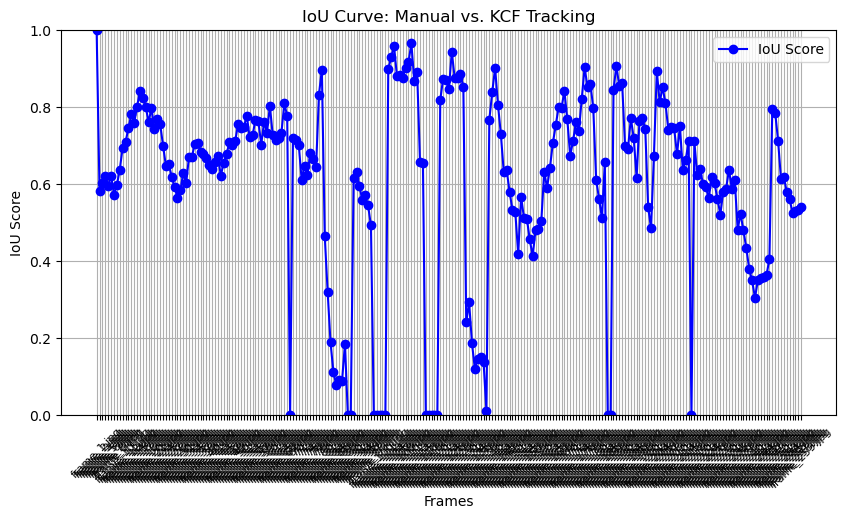

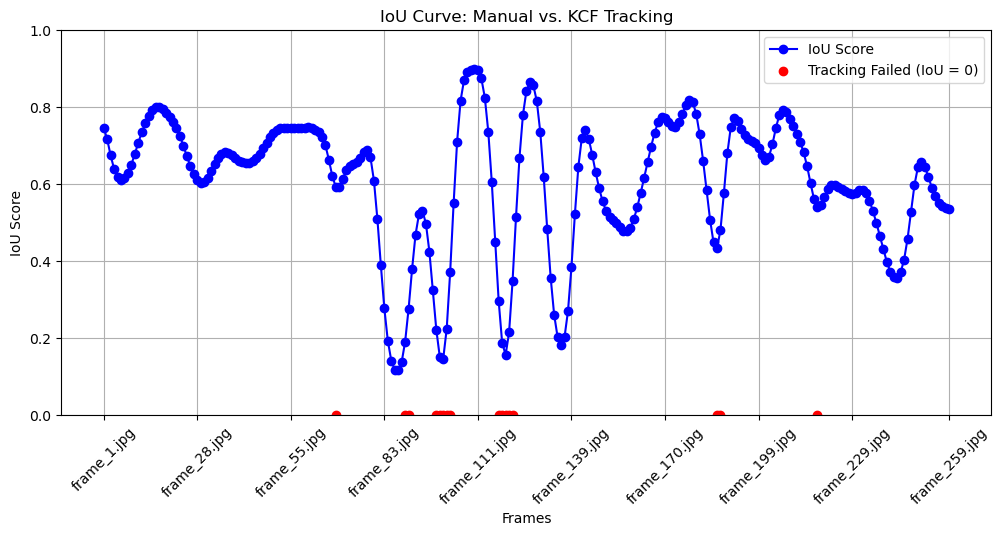

In [ ]:
from scipy.ndimage import gaussian_filter1d

# Paths to annotation files
manual_annotations_file = annotation_file
kcf_annotations_file = "/Users/Mac_1/Documents/Development/1.Projects/CV/CV-Final/video_tracking/KCF/KCF_annotations.txt"

def natural_sort_key(filename):
    """Extracts numbers from filenames to ensure correct numerical sorting."""
    numbers = re.findall(r'\d+', filename)  # Extract numbers
    return int(numbers[0]) if numbers else filename  # Convert to integer for sorting

# Function to read annotations from txt file
def load_annotations(file_path):
    annotations = {}
    with open(file_path, "r") as f:
        for line in f:
            parts = line.strip().split(",")
            if len(parts) < 5:
                continue  # Skip malformed lines
            frame_name = parts[0]
            x_min, y_min, x_max, y_max = map(int, parts[1:5])

            # If all coordinates are -1, mark as no detection
            if (x_min, y_min, x_max, y_max) == (-1, -1, -1, -1):
                annotations[frame_name] = None  # No detection
            else:
                annotations[frame_name] = (x_min, y_min, x_max, y_max)

    return annotations

# Function to compute IoU
def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    unionArea = boxAArea + boxBArea - interArea

    if unionArea == 0:
        return 0.0  # Avoid division by zero
    return interArea / unionArea

# Load annotations
manual_annotations = load_annotations(manual_annotations_file)
kcf_annotations = load_annotations(kcf_annotations_file)

# Compute IoU for matching frames
frames = []
iou_values = []

for frame_name in manual_annotations.keys():  # Ensure sorted order
    if frame_name in kcf_annotations:
        manual_box = manual_annotations[frame_name]
        kcf_box = kcf_annotations[frame_name]

        # If either annotation is missing, IoU = 0
        if manual_box is None or kcf_box is None:
            iou = 0.0
        else:
            iou = calculate_iou(manual_box, kcf_box)

        frames.append(frame_name)
        iou_values.append(iou)

# Plot IoU curve
plt.figure(figsize=(10, 5))
plt.plot(frames, iou_values, marker="o", linestyle="-", color="b", label="IoU Score")
plt.xlabel("Frames")
plt.ylabel("IoU Score")
plt.title("IoU Curve: Manual vs. KCF Tracking")
plt.xticks(rotation=45, fontsize=8)
plt.ylim(0, 1)  # IoU values range from 0 to 1
plt.grid(True)
plt.legend()
plt.show()


# Apply Gaussian smoothing for a cleaner curve
smoothed_iou = gaussian_filter1d(iou_values, sigma=2)

plt.figure(figsize=(12, 5))

# Plot IoU scores with a smoother curve
plt.plot(frames, smoothed_iou, marker="o", linestyle="-", color="b", label="IoU Score")

# Mark IoU = 0.0 points in red
zero_iou_frames = [frames[i] for i, iou in enumerate(iou_values) if iou == 0.0]
zero_iou_values = [0.0] * len(zero_iou_frames)
plt.scatter(zero_iou_frames, zero_iou_values, color="red", label="Tracking Failed (IoU = 0)")

# Improve X-axis readability:
num_labels = 10  # Adjust based on how many labels you want to show
frame_indices = np.linspace(0, len(frames) - 1, num_labels, dtype=int)  # Select evenly spaced frames
plt.xticks([frames[i] for i in frame_indices], rotation=45, fontsize=10)  # Show only selected frames

# Labels & Titles
plt.xlabel("Frames")
plt.ylabel("IoU Score")
plt.title("IoU Curve: Manual vs. KCF Tracking")
plt.ylim(0, 1)  # Keep IoU within [0,1]
plt.grid(True)
plt.legend()
plt.show()

